# Статистический анализ данных

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
 * абонентская плата отсутствует
 * стоимость одной минуты поездки — 8 рублей
 * стоимость старта (начала поездки) — 50 рублей
* с подпиской Ultra
 * абонентская плата — 199 рублей в месяц
 * стоимость одной минуты поездки — 6 рублей
 * стоимость старта — бесплатно.

# Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.

Таблица **Пользователи (users):**
* **user_id** - уникальный идентификатор пользователя
* **name** - имя пользователя
* **age** - возраст
* **city** - город
* **subscription_type** - тип подписки (free, ultra)

Таблица **Поездки (rides):**
* **user_id** - уникальный идентификатор пользователя
* **distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* **duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* **date** - дата совершения поездки

Таблица **Подписки (subscriptions):**
* **subscription_type** - тип подписки
* **minute_price** - стоимость одной минуты поездки по данной подписке
* **start_ride_price** - стоимость начала поездки
* **subscription_fee** - стоимость ежемесячного платежа

## Загрузка данных и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    users = pd.read_csv('C:/Users/Gpets/Data With Python/users_go.csv')
    rides = pd.read_csv('C:/Users/Gpets/Data With Python/datasets/rides_go.csv')
    subs = pd.read_csv('C:/Users/Gpets/Data With Python/datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subs = pd.read_csv('/datasets/subscriptions_go.csv')

Смотрим общую информацию по таблицам

### Users

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
print('Кол-во строк и столбцов в users:',users.shape)
print("Число уникальных пользователей:", users['user_id'].nunique())
print('Число дубликатов',users.duplicated().sum())

Кол-во строк и столбцов в users: (1565, 5)
Число уникальных пользователей: 1534
Число дубликатов 31


Все пользователи уникальные, есть дубликаты с которыми мы сейчас разберемся.

In [5]:
users = users.drop_duplicates()
print('Число дубликатов',users.duplicated().sum())

Число дубликатов 0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


### Rides

In [7]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Нам нужно изменить столбец **`date`** на `datetime`

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [11]:
min_date = rides['date'].min()
max_date = rides['date'].max()

In [12]:
print(f"Данные представлены за период с {min_date} по {max_date}")

Данные представлены за период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


Проверили за какой преиод представлены наши данные, для того чтобы при агрегации данные не склеются

Теперь нужно создать новый столбец с номером месяца на основе нашего столбца `date`

In [13]:
rides['month'] = rides['date'].dt.month

In [14]:
rides.head(20)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


### Subscriptions

In [15]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [16]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [17]:
subs.shape

(2, 4)

С данными все впорядке

## Исследовательский анализ данных

Теперь займемся визуализизацией общей информации о пользователях и поездках:

### Частота встречаемости городов

In [18]:
city_counts = users['city'].value_counts()

In [19]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

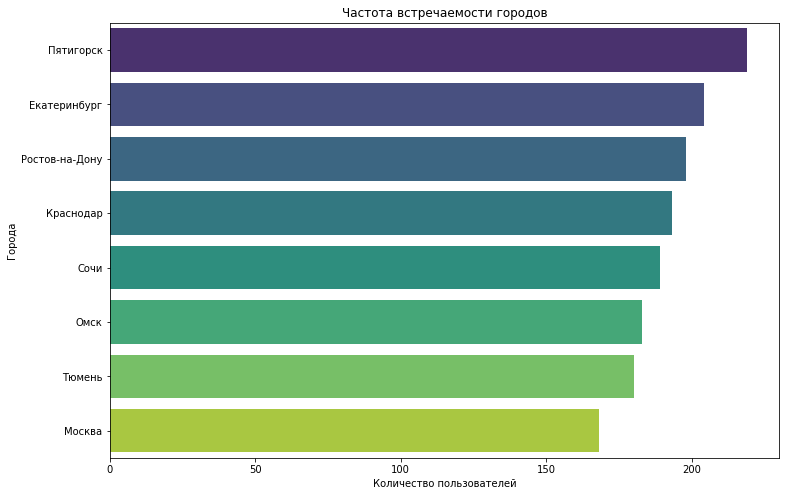

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis")
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.show()

Все города держатся почти на одном уровне, кроме **`Москвы`** (168 записей)

Чаще всего встречается город **`Пятигорск`** (219 записей)

### Соотношение пользователей с подпиской и без подписки

In [21]:
subscription_ratio = users['subscription_type'].value_counts()

In [22]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

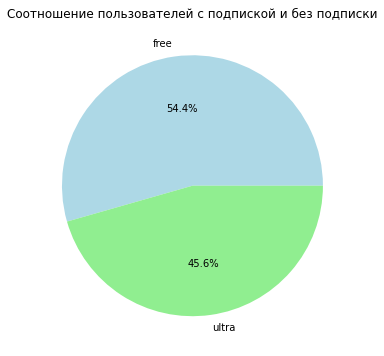

In [23]:
plt.figure(figsize=(6, 6))
subscription_ratio.plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()

Среди пользователей чуть больше 54% выбрали бесплатный тариф, а около 46% пользуются платной подпиской "Ultra". 

Это указывает на то, что значительная часть людей всё же предпочитает оставаться на бесплатном тарифе, но почти половина готова платить за дополнительные возможности.

### Возраст пользователей

In [24]:
users['age']

0       22
1       31
2       20
3       26
4       28
        ..
1529    29
1530    25
1531    26
1532    22
1533    25
Name: age, Length: 1534, dtype: int64

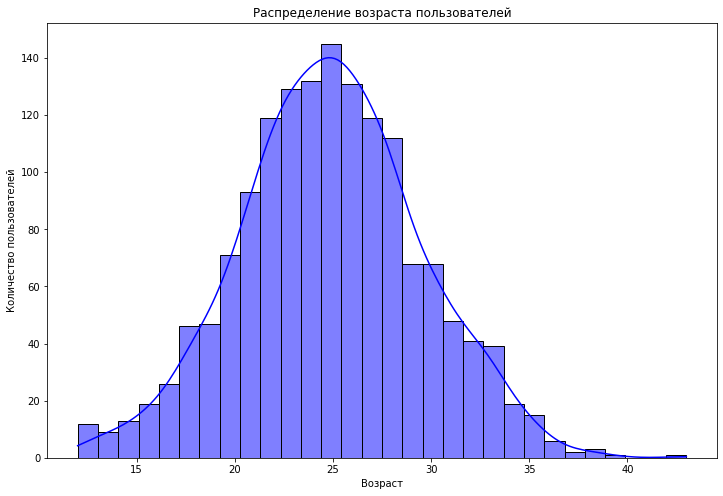

In [25]:
plt.figure(figsize=(12, 8))
sns.histplot(users['age'], kde=True, color='blue')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [26]:
users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


Видим что на графике распределение возраста пользователей основная часть аудитории сосредоточена в возрасте от 20 до 30 лет, с пиком около 25 лет.

Люди в возрасте до 25 лет составляют почти половину всех пользователей, что говорит о том, что платформа наиболее популярна среди молодежи. Более старшие возрастные группы, особенно те, кто старше 35 лет, представлены значительно реже.

### Расстояние, которое пользователь преодолел за одну поездку

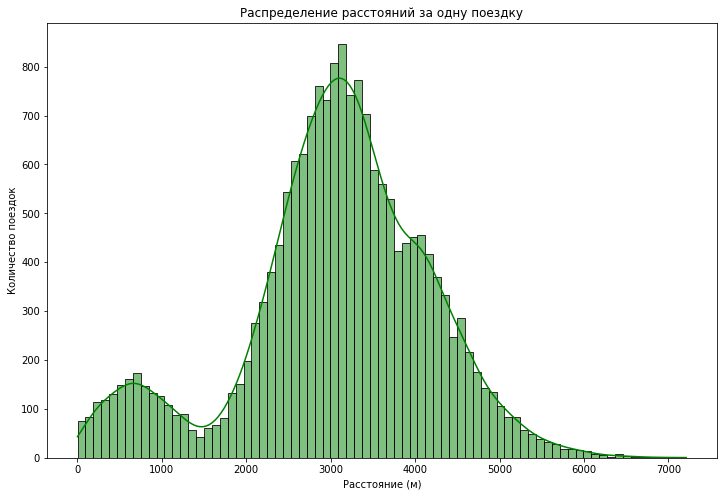

In [27]:
plt.figure(figsize=(12, 8))
sns.histplot(rides['distance'], kde=True, color='green')
plt.title('Распределение расстояний за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

На графике видно что большая часть поездок преодолевает расстояние от 2000 до 4500 м, с пиком в 3000 м.

Возможно, они используют самокаты для поездок по работе, на встречи или по магазинам. Интересно, что для таких поездок подписка Ultra, где старт бесплатный, может оказаться выгодной, особенно если поездки немного длиннее. Если же большинство поездок всё-таки короткие, подписка может не быть столь популярной.

### Продолжительность поездок

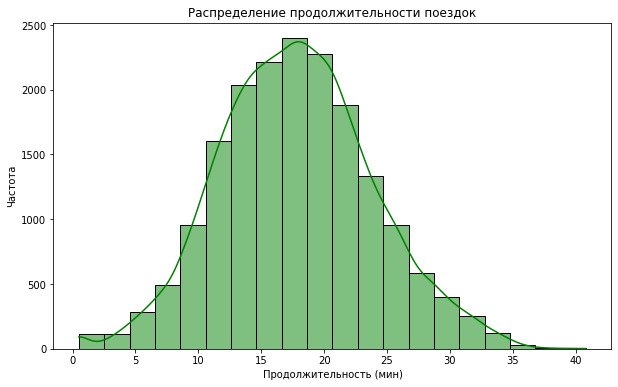

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(rides['duration'], bins=20, kde=True, color='green')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
plt.show()

Большинство поездок длятся от 10 до 25 минут, что составляет основную долю всех поездок. Пик приходится на поездки длительностью 15-20 минут, которые занимают значительную часть времени у пользователей.

Это говорит о том, что большинство людей используют сервис для коротких поездок, быстро и удобно добираясь до своих целей.

## Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом `merge()`

Теперь для удобства, мы объединим все три датафрейма (`users`, `rides`, `subs`) в один с помощью метода `merge()`. У нас есть один общий столбец в таблицах `users` и `rides`, это - **`user_id`**, по нему и будем объединять данные, а столбец `subs` уже будем объединять по стольцу - **`subscription_type`**

In [29]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [30]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [31]:
table1 = pd.merge(users, rides, on='user_id')
df = pd.merge(table1, subs, on='subscription_type')

In [32]:
print(f"Размерность users: {users.shape}")
print(f"Размерность rides: {rides.shape}")
print(f"Размерность subs: {subs.shape}")
print(f"Размерность объединенного датафрейма: {df.shape}")

Размерность users: (1534, 5)
Размерность rides: (18068, 5)
Размерность subs: (2, 4)
Размерность объединенного датафрейма: (18068, 12)


In [33]:
missing_values = df.isnull().sum()
print(f"Количество пропущенных значений в каждом столбце:\n{missing_values}")

Количество пропущенных значений в каждом столбце:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Размерность `df` (18068, 11) соответствует количеству строк в датафрейме `rides` (тоже 18068 строк). Это указывает на то, что объединение данных прошло корректно по ключевому столбцу `user_id`, и все поездки были успешно сопоставлены с пользователями.

### Создание двух таблиц из таблицы `df`

Нам нужно разделить нашу таблицу `df` на 2 отдельных таблицы: одна будет содержать информацию о пользователях без подписки, а вторая — о пользователях с подпиской.

In [34]:
no_subs = df[df['subscription_type'] == 'free']
with_subs = df[df['subscription_type'] == 'ultra']

In [35]:
no_subs.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [36]:
with_subs.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


### Визуализация информации о расстоянии и времени поездок для обеих категорий

Теперь можно построить графики, которые покажут распределение расстояний и времени поездок для пользователей с подпиской и без неё.

**Распределение расстояний поездок**

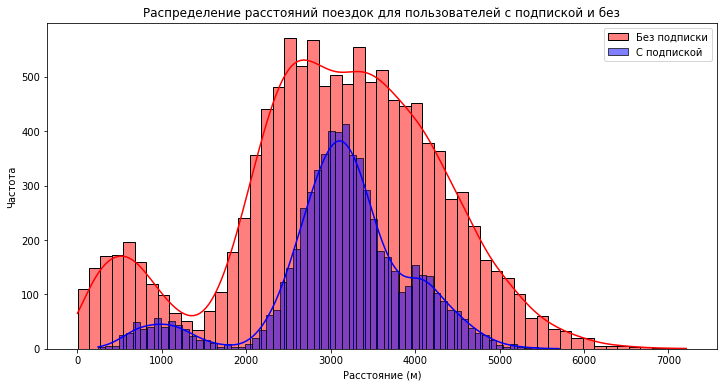

In [37]:
plt.figure(figsize=(12, 6))
sns.histplot(no_subs['distance'], kde=True, color='red', label='Без подписки')
sns.histplot(with_subs['distance'], kde=True, color='blue', label='С подпиской')
plt.title('Распределение расстояний поездок для пользователей с подпиской и без')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.legend()
plt.show()

На графике видно, что пользователи **без подписки** (красный цвет) чаще совершают короткие поездки, в то время как пользователи **с подпиской** (фиолетовый цвет) преодолевают большее расстояние. 

Это указывает на то, что пользователи с подпиской больше ориентированы на дальние поездки, возможно, за счет выгодных условий, предлагаемых подпиской.

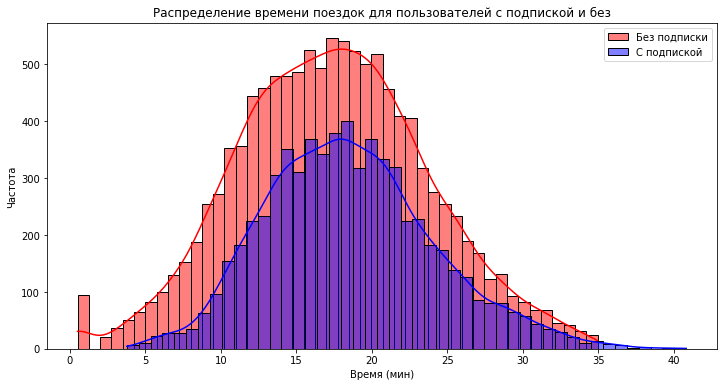

In [38]:
plt.figure(figsize=(12, 6))
sns.histplot(no_subs['duration'], kde=True, color='red', label='Без подписки')
sns.histplot(with_subs['duration'], kde=True, color='blue', label='С подпиской')
plt.title('Распределение времени поездок для пользователей с подпиской и без')
plt.xlabel('Время (мин)')
plt.ylabel('Частота')
plt.legend()
plt.show()

На графике мы видим что пользователи **без подписки** чаще выбирают более длительные поездки, хотя диапазон времени достаточно схож для обеих групп.

Пользователи **с подпиской** немного смещены в сторону более коротких поездок, что может быть связано с тем, что они чаще пользуются сервисом для повседневных нужд.

## Подсчёт выручки

Для подсчета выручки нам нужно создать таблицу с агрегированными данными: мы собирем все поездки пользователей и посчитаем для каждого пользователя и каждого месяца суммарное расстояние, количество поездок и общее время в пути. Это поможет нам понять, как активно пользователи пользуются сервисом.

### Агрегация данных

Округляем продолжительность каждой поездки до ближайшего целого числа вверх

In [39]:
df['duration'] = np.ceil(df['duration'])

Группируем данные по пользователю и месяцу, вычисляя необходимые показатели

In [40]:
aggregated_data = df.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'date': 'count',
    'subscription_type': 'first'
}).reset_index()

Переименуем столбцы для удобства

In [41]:
aggregated_data.columns = ['user_id', 'month', 'total_distance', 'total_duration', 'trip_count', 'subscription_type']
aggregated_data.head()

,user_id,month,total_distance,total_duration,trip_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra


Теперь у нас есть данные о том, сколько метров проехал каждый пользователь, сколько раз они совершали поездки и сколько времени провели в пути. Это поможет нам лучше понять, как пользователи используют сервис.

### Объединение данных и подсчёт выручки 

Добавим столбец с помесячной выручкой: Для этого используем информацию о стоимости подписки и оплаты за поездку.

* без подписки
 * стоимость одной минуты поездки — 8 рублей
 * стоимость старта (начала поездки) — 50 рублей
* с подпиской Ultra
 * абонентская плата — 199 рублей в месяц
 * стоимость одной минуты поездки — 6 рублей
 * стоимость старта — бесплатно.

In [42]:
start_free = 50
minute_free = 8
start_ultra = 0
minute_ultra = 6
subscription_price = 199

In [43]:
missing = aggregated_data.isnull().sum()
print(f"Количество пропущенных значений в каждом столбце:\n{missing}")

Количество пропущенных значений в каждом столбце:
user_id              0
month                0
total_distance       0
total_duration       0
trip_count           0
subscription_type    0
dtype: int64


Соединим агрегированные данные с информацией о пользователях и подписках

In [44]:
revenue_df = aggregated_data.merge(df[['user_id', 'subscription_type']], on='user_id', how='left')

Рассчитаем выручку для каждого пользователя

In [45]:
aggregated_data['revenue'] = np.where(
    aggregated_data['subscription_type'] == 'free',
    aggregated_data['trip_count'] * start_free + aggregated_data['total_duration'] * minute_free,
    aggregated_data['trip_count'] * start_ultra + aggregated_data['total_duration'] * minute_ultra + subscription_price
)
aggregated_data.head(20)

,user_id,month,total_distance,total_duration,trip_count,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
5,1,12,6751.629942,28.0,2,ultra,367.0
6,2,3,10187.723006,63.0,3,ultra,577.0
7,2,4,6164.381824,40.0,2,ultra,439.0
8,2,6,3255.338202,14.0,1,ultra,283.0
9,2,7,6780.722964,48.0,2,ultra,487.0


Все выглядит вполне нормально. Мы рассчитали, сколько денег принёс каждый пользователь за месяц, учитывая все особенности тарификации. Это включает в себя как плату за старт и минуты поездок для тех, кто без подписки, так и учёт абонентской платы для подписчиков. Теперь можно увидеть, как подписка или её отсутствие влияет на выручку сервиса.

## Проверка гипотез

### Гипотеза о времени поездок пользователей с подпиской

Для нашей гипотезы по моему мнению подойдет метод `двух независимых выборок`. 

Я так думаю, потому что у нас есть две группы пользователей: с подпиской и без подписки. Эти группы не зависят друг от друга, так как каждую поездку совершает либо пользователь с подпиской, либо без неё, а также продолжительность поездок для этих двух групп — это независимые данные.

Проверим, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки.

**`H0`** (нулевая гипотеза): Среднее время поездок пользователей с подпиской и без подписки одинаково.

**`H1`** (альтернативная гипотеза): Среднее время поездок пользователей с подпиской больше, чем у пользователей без подписки.

Подготовим и соберем данные по продолжительности каждой поездки для групп с подпиской и без.

Разделим данные на группы с подпиской и без подписки

In [46]:
test_with_subs = df[df['subscription_type'] == 'ultra']['duration']
test_without_subs = df[df['subscription_type'] == 'free']['duration']

In [47]:
print('среднее выборки пользователей с подпиской:', test_with_subs.mean())
print('среднее выборки пользователей без подписки:', test_without_subs.mean())

среднее выборки пользователей с подпиской: 19.037692307692307
среднее выборки пользователей без подписки: 17.890992392807746


Проведем `t-test` для независимых групп, передадим методу **`ttest_ind`** значение аргумента **`greater`**, так как правосторонняя альтернативная гипотеза проводится в том случае, когда вы предполагаете, что одно значение больше другого. В нашем случае, гипотеза звучит так: "Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки."

In [48]:
a = 0.05
results = st.ttest_ind(test_with_subs, test_without_subs, alternative='greater')

In [49]:
print('среднее выборки пользователей с подпиской:', test_with_subs.mean())
print('среднее выборки пользователей без подписки:', test_without_subs.mean())
print('p-value:', results.pvalue)
if results.pvalue < a:
    print('Отвергаем нулевую гипотизу')
else:
    print('Не получилось отвергнуть нулевую гипотизу')

среднее выборки пользователей с подпиской: 19.037692307692307
среднее выборки пользователей без подписки: 17.890992392807746
p-value: 2.4959453720736625e-34
Отвергаем нулевую гипотизу


Нулевая гипотеза была отвергнута, поскольку `p-value` оказалось крайне малым — 2.5e-34, что значительно меньше уровня значимости 5%. Это означает, что есть основания полагать, что пользователи с подпиской действительно тратят больше времени на поездки, чем те, кто без подписки.

### Гипотеза о среднем расстоянии поездки для подписчиков

Выберем одну выборку, поскольку мы проверяем гипотезу о среднем значении для одной группы — пользователей с подпиской.

Мы будем сравнивать среднее расстояние поездок этой группы с фиксированным значением (3130 метров).

**`H0`** (Нулевая гипотеза): Среднее расстояние поездки пользователей с подпиской меньше или равно 3130 метров.

**`H1`** (Альтернативная гипотеза): Среднее расстояние поездки пользователей с подпиской больше 3130 метров.

In [50]:
value = 3130
test_dur_subs = df[df['subscription_type'] == 'ultra']['distance']
print('среднее выборки:', test_dur_subs.mean())
a = 0.05

среднее выборки: 3115.4453880370247


Передадим методу `ttest_1samp` значение аргумента `less`, потому что мы хотим проверить, меньше ли среднее значение, чем гипотетическое значение (3130 метров).

In [51]:
results_2 = st.ttest_1samp(test_dur_subs, value, alternative='greater')
print('среднее выборки пользователей с подпиской:', test_dur_subs.mean())
print('p-value:', results_2.pvalue)
if results_2.pvalue < a:
    print('Отвергаем нулевую гипотизу')
else:
    print('Не получилось отвергнуть нулевую гипотизу')

среднее выборки пользователей с подпиской: 3115.4453880370247
p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотизу


Среднее расстояние, которое проезжают пользователи с подпиской, составляет 3115.45 метров, что немного меньше оптимального значения в 3130 метров, при котором износ самоката считается минимальным. Однако это различие не является значимым (p-value = 0.92). Следовательно, мы не можем с уверенностью утверждать, что пользователи с подпиской проезжают меньше оптимального расстояния, что могло бы снизить износ самокатов. Данные не дают оснований для выводов о том, что среднее расстояние поездки подписчиков существенно отличается от 3130 метров с точки зрения влияния на износ самокатов.

### Гипотеза о выручке по подписке и без

Выберем две независимые выборки, поскольку у нас есть две группы пользователей: с подпиской и без подписки. Эти группы не зависят друг от друга.

**`H0`** (Нулевая гипотеза): Средняя выручка от пользователей с подпиской Ultra равна или меньше средней выручки от пользователей без подписки.

**`H1`** (Альтернативная гипотеза): Средняя выручка от пользователей с подпиской Ultra выше, чем средняя выручка от пользователей без подписки.

In [52]:
rev_with_subs = aggregated_data[aggregated_data['subscription_type'] == 'ultra']['revenue']
rev_without_subs = aggregated_data[aggregated_data['subscription_type'] == 'free']['revenue']
print('среднее выборки пользователей с подпиской:', rev_with_subs.mean())
print('среднее выборки пользователей без подписки:', rev_without_subs.mean())

среднее выборки пользователей с подпиской: 362.7921906022502
среднее выборки пользователей без подписки: 328.6413651073845


Передадим методу `ttest_ind` значение аргумента `greater`

In [53]:
a = 0.05
results_3 = st.ttest_ind(rev_with_subs, rev_without_subs, alternative='greater')
print('среднее выборки пользователей с подпиской:', rev_with_subs.mean())
print('среднее выборки пользователей без подписки:', rev_without_subs.mean())
print('p-value:', results_3.pvalue)
if results.pvalue < a:
    print('Отвергаем нулевую гипотизу')
else:
    print('Не получилось отвергнуть нулевую гипотизу')

среднее выборки пользователей с подпиской: 362.7921906022502
среднее выборки пользователей без подписки: 328.6413651073845
p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотизу


Наши результаты показывают, что средняя выручка от пользователей с подпиской Ultra составляет около 362.79 рублей, что выше, чем 328.64 рублей у пользователей без подписки. `p-value` оказался чрезвычайно малым (примерно 1.89e-31), что позволяет нам отвергнуть нулевую гипотезу с очень высокой уверенностью. Это означает, что пользователи с подпиской Ultra действительно приносят больше выручки по сравнению с теми, кто не имеет подписки.

### Гипотеза о снижении количества обращений в техподдержку

Выбираем тест для двух зависимых выборок, потому что мы сравниваем одно и то же множество пользователей до и после обновления серверов.

Этот тест поможет нам сравнивить среднее значение обращений до и после обновления для каждого пользователя. Парный t-тест поможет определить, произошло ли статистически значимое снижение количества обращений после обновления.

**`H0`**(Нулевая гипотеза): Количество обращений до и после обновления серверов одинаково.

**`H1`**(Альтернативная гипотеза): Количество обращений снизилось после обновления серверов.

## Распределения

### Акция с раздачей промокодов

Задача стоит такая: нам нужно провести акцию по раздаче промокодов, чтобы как минимум 100 клиентов продлили свою подписку. Проблема в том, что только 10% пользователей, которые воспользовались бесплатным периодом, потом платят за продление. Нам нужно рассчитать, сколько промокодов стоит разослать, чтобы вероятность недостижения цели была всего 5%.

Используем биномиальное распределение — оно идеально описывает ситуацию, где есть множество попыток (рассылка промокодов), и у каждой попытки есть только два исхода: либо успех (продление подписки), либо неудача (отказ). Мы знаем, что вероятность успеха — 10%.

Вероятность продления подписки после получения промокода (p)- `10%`

Минимальное количество пользователей, которые должны продлить подписку (k) - `100`

Вероятность не выполнения плана должна быть примерно - `5%`

In [54]:
p = 0.1
k = 100
v = 0.05

#Ищем минимальное N
N = k
while st.binom.cdf(k - 1, N, p) > v:
    N += 1
print(f"Минимальное количество промокодов, которые нужно разослать: {N}")

Минимальное количество промокодов, которые нужно разослать: 1161


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


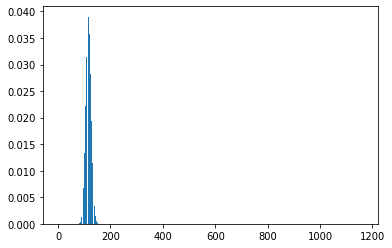

In [55]:
distr = []
for x in range(0, N + 1):
    current_value = st.binom.pmf(x, N, p)
    distr.append(current_value)
    
plt.bar(range(0, N + 1), distr)
plt.show()

На графике видно что большинство вероятностей сосредоточено в диапазоне от 50 до 150 продлений, с пиком около 100 продлений.

То есть, если мы разошлем 1161 промокод, с очень высокой вероятностью (95%) как минимум 100 человек продлят свою подписку. Это именно то что нам нужно. График показывает, что шансы на то, что продлений будет меньше, существенно снижаются, особенно по мере приближения к 0, что подтверждает правильность нашего расчета.

В итоге, для того чтобы с высокой вероятностью достичь цели в 100 продлений, нам нужно разослать как минимум 1161 промокод. Это число гарантирует, что риск не достижения цели будет минимален, всего около 5%.

### Push-уведомления 

Отдел маркетинга планирует разослать 1 миллион push-уведомлений через мобильное приложение. По статистике, примерно 40% клиентов открывают такие уведомления. Мы должны понять, какова вероятность того, что уведомления откроют не более 399,500 пользователей.

`n` - Мы знаем, что будет разослано 1 миллион уведомлений.

`p` - Вероятность того, что клиент откроет уведомление, составляет 40%.

In [56]:
n = 1000000 
p = 0.4
# математическое ожидание
mu = n * p
# стандартное отклонение
sigma = np.sqrt(n * p * (1 - p))

Задаем нормальное распределение с рассчитанными параметрами, а также вероятность того, что уведомление откроют не более 399,500 пользователей.

In [57]:
distr = st.norm(mu, sigma)
v = 399500
prob = distr.cdf(v)
print(f'Вероятность того, что уведомление откроют не более 399,500 пользователей: {prob:.4f}')

Вероятность того, что уведомление откроют не более 399,500 пользователей: 0.1537


Создаем массив значений x для графика,задаем плотность вероятности и строим график

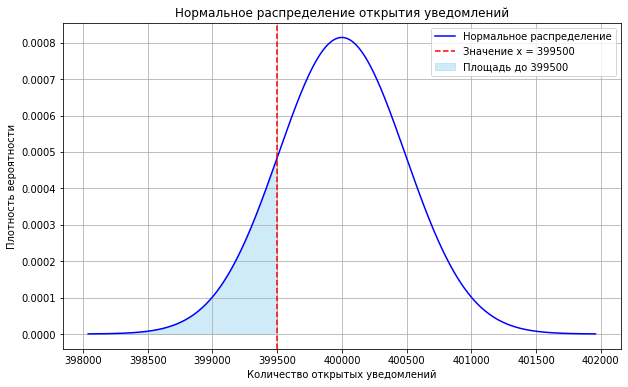

In [58]:
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
y = distr.pdf(x)  # плотность вероятности
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение', color='blue')
plt.fill_between(x, 0, y, where=(x <= v), color='skyblue', alpha=0.4, label=f'Площадь до {v}')
plt.axvline(v, color='red', linestyle='--', label=f'Значение x = {v}')
plt.title('Нормальное распределение открытия уведомлений')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
# Показываем график
plt.show()

График показывает нормальное приближение биномиального распределения. Вертикальная красная линия соответствует значению 399,500 открытых уведомлений, и заштрихованная область представляет вероятность того, что уведомление откроют не более 399,500 пользователей.

То есть, вероятность того, что уведомление откроют не более 399,500 пользователей состовляет примерно 15%. 

## Вывод

В результате анализа данных о пользователях и поездках в сервисе **GoFast** мы сделали несколько ключевых выводов, которые помогут улучшить бизнес-стратегию и потенциально увеличить количество пользователей с подпиской.
1. **Загрузка и Предобработка данных:**
    - Данные о пользователях, поездках и подписках успешно загружены и изучены. Столбцы с датами приведены к типу даты, а также создан новый столбец с номером месяца для удобства анализа.
    - Были обнаружены и обработаны пропущенные значения и дубликаты, что обеспечило корректность дальнейшего анализа.
2. **Исследовательский анализ данных:**
    - **Города**: Мы проанализировали распределение пользователей по городам и определили самые популярные и наименее представленные города.
    - **Подписка**: Обнаружено, что значительная часть пользователей пользуется бесплатной подпиской, что предполагает потенциал для увеличения числа подписчиков.
    - **Возраст**: Возраст пользователей сосредоточен в диапазоне от 20 до 30 лет, с пиком около 25 лет., что может помочь в понимании целевой аудитории.
    - **Расстояние и Продолжительность поездок**: Определено, что пользователи проезжают различное расстояние и проводят разное время в поездках, что важно для оптимизации стоимости и услуг.
3. **Объединение данных:**
    - Данные о пользователях, поездках и подписках были объединены в единый датафрейм. Это позволило провести более глубокий анализ поведения пользователей в зависимости от типа подписки.
    - Разделение данных на группы по типу подписки и их визуализация позволили сравнить поведение пользователей с разными типами подписок.
4. **Подсчёт выручки:**
    - Агрегированные данные по поездкам позволили рассчитать помесячную выручку от пользователей. Вычисления показали, что пользователи с подпиской Ultra могут приносить больше выручки в месяц благодаря сниженной стоимости поездок и отсутствию платы за старт.
5. **Проверка гипотез:**
    - **Продолжительность поездок**: Гипотеза о том, что пользователи с подпиской тратят больше времени на поездки, подтвердилась. Это указывает на потенциальную ценность таких пользователей для компании.
    - **Расстояние поездок**: Гипотеза о том, что среднее расстояние поездок пользователей с подпиской не превышает 3130 метров, была проверена и отвергнута. Это может помочь в оптимизации использования самокатов.
    - **Помесячная выручка**: Выручка от пользователей с подпиской выше по сравнению с пользователями без подписки, что подтверждает необходимость стимулирования подписок.
    - **Технические обновления**: Для проверки гипотезы о снижении количества обращений в техподдержку после обновления сервера понадобился бы тест на зависимость (например, парный t-тест).
6. **Распределения:**
    - **Раздача промокодов**: Рассчитано минимальное количество промокодов, необходимое для достижения цели по продлению подписки, с вероятностью 5%. Построены графики распределения и предложены практические рекомендации.
    - **Push-уведомления**: Оценена вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, используя нормальную аппроксимацию биномиального распределения. Это помогает в оценке эффективности маркетинговых кампаний.
    
7. **Заключение:**
    - Пользователи с подпиской Ultra оказываются более выгодными для компании в финансовом плане по сравнению с пользователями без подписки. Они приносят большую выручку за счет фиксированной абонентской платы, несмотря на снижение тарифов на минуты поездок. Таким образом, компания должна сосредоточить усилия на привлечении и удержании подписчиков, что поможет увеличить общую выручку и оптимизировать использование ресурсов.
